# Persiapan Awal

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

# Cek GPU
device_name = tf.test.gpu_device_name()
print('Sukses! GPU ditemukan di: {}'.format(device_name) if device_name == '/device:GPU:0' else 'GPU tidak ditemukan')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sukses! GPU ditemukan di: /device:GPU:0


In [ ]:
# Path asal di Drive (pastikan sesuai dengan folder Anda)
drive_path = '/content/drive/MyDrive/UAP Machine Learning/Indonesian Spices Dataset'
# Path tujuan di lokal Colab
local_path = '/content/dataset_rempah'

if not os.path.exists(local_path):
    print("Sedang menyalin dataset ke lokal Colab... Harap tunggu.")
    shutil.copytree(drive_path, local_path)
    print("Penyalinan selesai!")
else:
    print("Dataset sudah tersedia di lokal Colab.")

Sedang menyalin dataset ke lokal Colab... Harap tunggu.
Penyalinan selesai!



Menampilkan 5 contoh gambar acak dari dataset:


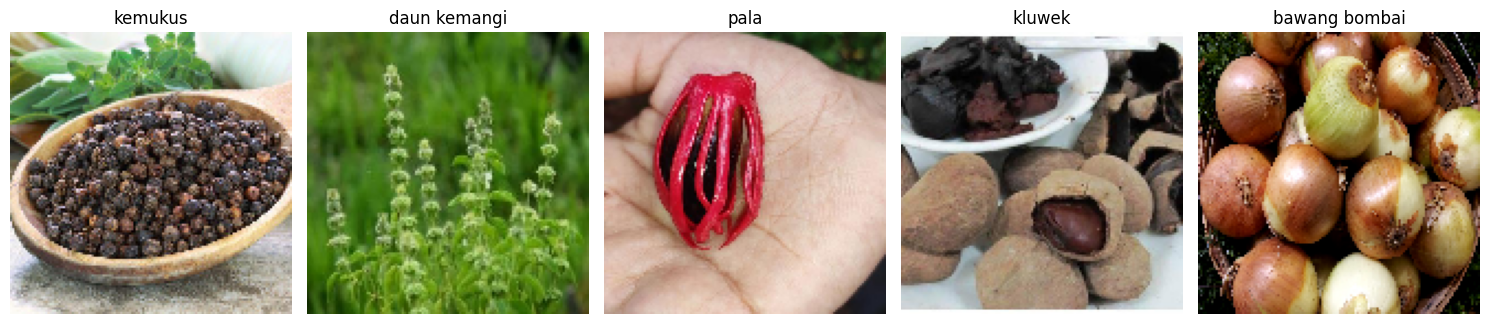

In [ ]:
# Preview 5 Gambar Acak
print("\nMenampilkan 5 contoh gambar acak dari dataset:")
all_classes = [d for d in os.listdir(local_path) if os.path.isdir(os.path.join(local_path, d))]

plt.figure(figsize=(15, 5))
for i in range(5):
    # Pilih kelas acak
    random_class = random.choice(all_classes)
    class_path = os.path.join(local_path, random_class)

    # Pilih gambar acak dari kelas tersebut
    random_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_img)

    # Tampilkan
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(random_class)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Splitting dan Normalisasi Data

In [ ]:
# 1. Parameter Pelatihan
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
base_dir = '/content/dataset_rempah'

# 2. Konfigurasi ImageDataGenerator (Hanya Rescale & Splitting)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# 3. Memuat Data Training (80%)
print("Memuat Data Training:")
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# 4. Memuat Data Validation (20%)
print("\nMemuat Data Validation:")
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Memuat Data Training:
Found 5208 images belonging to 31 classes.

Memuat Data Validation:
Found 1302 images belonging to 31 classes.


# Arsitektur CNN dari awal (Non-Pretrained)

In [ ]:
model_base = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model_base.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_base.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,954,719 (49.42 MB)

 Trainable params: 12,954,719 (49.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Konfigurasi Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Memulai pelatihan Model Base...")
history_base = model_base.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stop]
)

Memulai pelatihan Model Base...
Epoch 1/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 45s 279ms/step - accuracy: 0.6788 - loss: 1.0282 - val_accuracy: 0.5086 - val_loss: 1.7724
Epoch 2/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7500 - loss: 0.8243 - val_accuracy: 0.5008 - val_loss: 1.8189
Epoch 3/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 30s 187ms/step - accuracy: 0.7844 - loss: 0.7177 - val_accuracy: 0.5148 - val_loss: 1.8383
Epoch 4/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8125 - loss: 0.5672 - val_accuracy: 0.5164 - val_loss: 1.8661
Epoch 5/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 42s 257ms/step - accuracy: 0.8378 - loss: 0.5130 - val_accuracy: 0.5289 - val_loss: 1.8762
Epoch 6/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8750 - loss: 0.3933 - val_accuracy: 0.5398 - val_loss: 1.8680
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


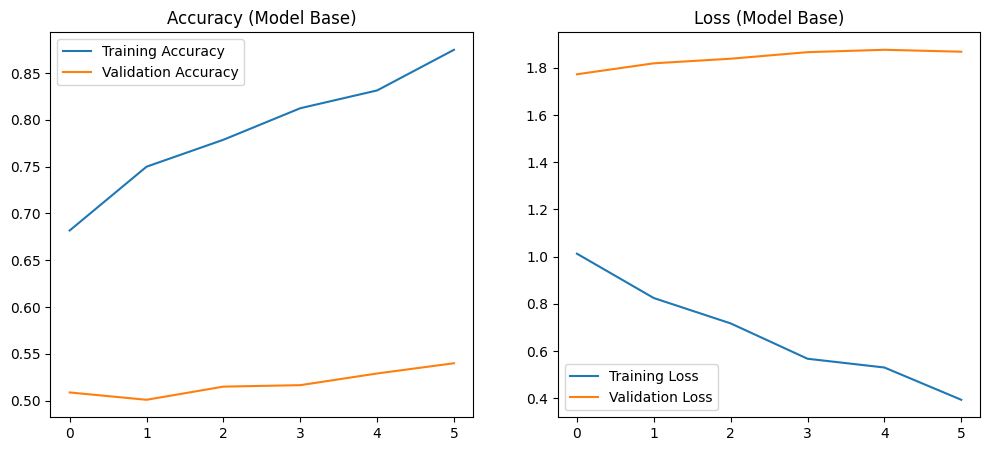

In [ ]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']
loss = history_base.history['loss']
val_loss = history_base.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy (Model Base)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss (Model Base)')
plt.legend()
plt.show()

# Model Pre-trained 1 (MobileNetV2)

1. Implementasi Model Pre-trained 1 (MobileNetV2)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# 1. Load Model Pre-trained (Transfer Learning)
# Tanpa top layer (FC layer) karena kita akan sesuaikan dengan 31 kelas rempah
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base model (agar bobot asli dari ImageNet tidak berubah di awal training)
base_mobilenet.trainable = False

# 2. Menambahkan Layer Baru Sesuai Dataset Kita
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x) # Pengganti Flatten untuk model pretrained
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# 3. Menggabungkan Model
model_pretrained_1 = Model(inputs=base_mobilenet.input, outputs=predictions)

# 4. Compile Model
model_pretrained_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_pretrained_1.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,929,759 (11.18 MB)

 Trainable params: 671,775 (2.56 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

2. Pelatihan Model Pre-trained 1 (MobileNetV2)

In [ ]:
# 1. Konfigurasi Early Stopping khusus untuk Model Pre-trained
early_stop_pretrained = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 2. Proses Training Model Pre-trained 1
print("Memulai pelatihan Model Pre-trained 1 (MobileNetV2)...")
history_pretrained_1 = model_pretrained_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30, # Tetap 30 karena ada Early Stopping
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stop_pretrained]
)

Memulai pelatihan Model Pre-trained 1 (MobileNetV2)...
Epoch 1/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 62s 282ms/step - accuracy: 0.4310 - loss: 2.1340 - val_accuracy: 0.7922 - val_loss: 0.7015
Epoch 2/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6875 - loss: 1.0317 - val_accuracy: 0.7906 - val_loss: 0.7007
Epoch 3/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.7982 - loss: 0.6472 - val_accuracy: 0.7852 - val_loss: 0.7040
Epoch 4/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8125 - loss: 0.5226 - val_accuracy: 0.7891 - val_loss: 0.7011
Epoch 5/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.8725 - loss: 0.3866 - val_accuracy: 0.8188 - val_loss: 0.6092
Epoch 6/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9688 - loss: 0.1554 - val_accuracy: 0.8148 - val_loss: 0.6107
Epoch 7/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 65s 180ms/step - accuracy: 0.9161 - loss: 0.2653 - val_accuracy: 0.8203 - val_loss: 0.6237
Epoch 8/30
162/162 ━━━━━━━━━━━━━━━

3. Visualisasi Grafik Model Pre-trained 1 (MobileNetV2)

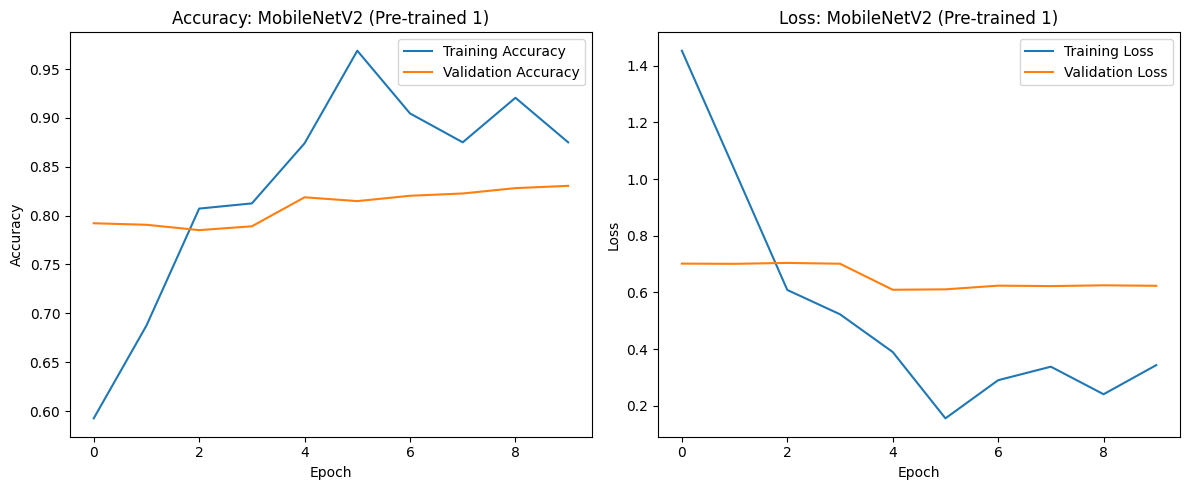

In [ ]:
import matplotlib.pyplot as plt

acc = history_pretrained_1.history['accuracy']
val_acc = history_pretrained_1.history['val_accuracy']
loss = history_pretrained_1.history['loss']
val_loss = history_pretrained_1.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy: MobileNetV2 (Pre-trained 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss: MobileNetV2 (Pre-trained 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Pre-trained 2 (VGG16)

1. Implementasi Model Pre-trained 2 (VGG16)

In [ ]:
from tensorflow.keras.applications import VGG16

# 1. Load Model VGG16 (Pre-trained)
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base model agar bobot asli tidak berubah
base_vgg16.trainable = False

# 2. Menambahkan Layer Klasifikasi Baru
x = base_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# 3. Menggabungkan dan Compile
model_pretrained_2 = Model(inputs=base_vgg16.input, outputs=predictions)
model_pretrained_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_pretrained_2.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,993,247 (57.19 MB)

 Trainable params: 278,559 (1.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

2. Pelatihan Model Pre-trained 2 (VGG16)

In [ ]:
print("Memulai pelatihan Model Pre-trained 2 (VGG16)...")
history_pretrained_2 = model_pretrained_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stop_pretrained] # Menggunakan callback yang sama
)

Memulai pelatihan Model Pre-trained 2 (VGG16)...
Epoch 1/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 49s 247ms/step - accuracy: 0.1658 - loss: 3.0932 - val_accuracy: 0.4812 - val_loss: 1.9672
Epoch 2/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2812 - loss: 2.4709 - val_accuracy: 0.4750 - val_loss: 1.9636
Epoch 3/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 31s 193ms/step - accuracy: 0.4581 - loss: 1.9007 - val_accuracy: 0.5234 - val_loss: 1.6271
Epoch 4/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.3438 - loss: 2.0230 - val_accuracy: 0.5273 - val_loss: 1.6260
Epoch 5/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 33s 204ms/step - accuracy: 0.5567 - loss: 1.5305 - val_accuracy: 0.5820 - val_loss: 1.4287
Epoch 6/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5938 - loss: 1.4163 - val_accuracy: 0.5852 - val_loss: 1.4302
Epoch 7/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - accuracy: 0.5934 - loss: 1.3487 - val_accuracy: 0.6219 - val_loss: 1.3345
Epoch 8/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 

3. Visualisasi Grafik Model Pre-trained 2 (VGG16)

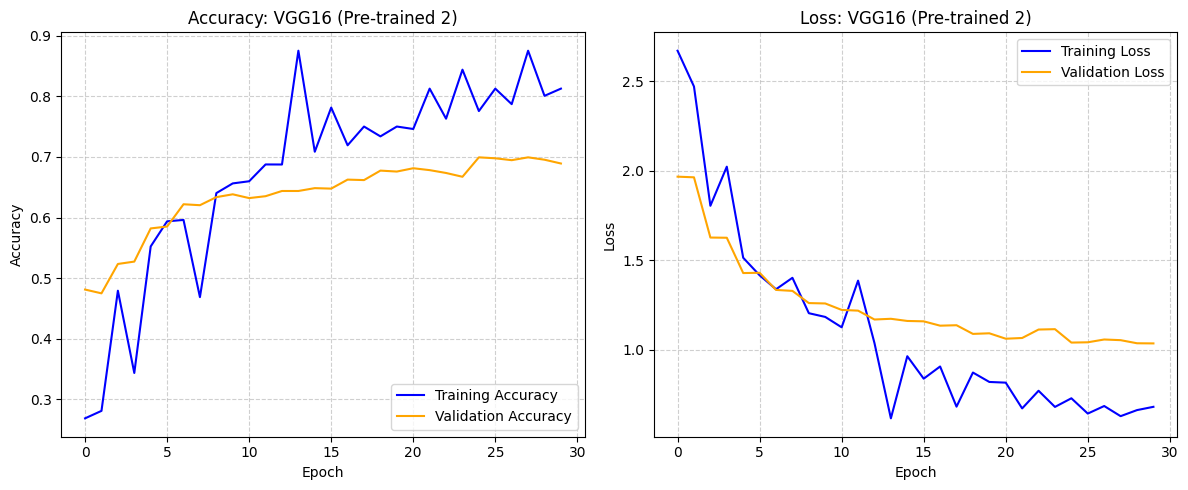

In [ ]:
# 1. Mengambil data history dari pelatihan VGG16
acc_vgg = history_pretrained_2.history['accuracy']
val_acc_vgg = history_pretrained_2.history['val_accuracy']
loss_vgg = history_pretrained_2.history['loss']
val_loss_vgg = history_pretrained_2.history['val_loss']
epochs_range_vgg = range(len(acc_vgg))

# 2. Membuat Plot Visualisasi
plt.figure(figsize=(12, 5))

# Subplot 1: Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range_vgg, acc_vgg, label='Training Accuracy', color='blue')
plt.plot(epochs_range_vgg, val_acc_vgg, label='Validation Accuracy', color='orange')
plt.title('Accuracy: VGG16 (Pre-trained 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range_vgg, loss_vgg, label='Training Loss', color='blue')
plt.plot(epochs_range_vgg, val_loss_vgg, label='Validation Loss', color='orange')
plt.title('Loss: VGG16 (Pre-trained 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Evaluasi Akhir (Classification Report & Confusion Matrix)

1. Evaluasi Model Base (Non-Pretrained)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step
EVALUASI MODEL BASE
               precision    recall  f1-score   support

         adas       0.74      0.62      0.68        42
    andaliman       0.76      0.60      0.67        42
    asam jawa       0.50      0.79      0.61        42
bawang bombai       0.62      0.50      0.55        42
 bawang merah       0.57      0.88      0.69        42
 bawang putih       0.28      0.79      0.42        42
biji ketumbar       0.56      0.60      0.57        42
 bukan rempah       0.85      0.79      0.81        42
 bunga lawang       0.48      0.71      0.57        42
      cengkeh       0.57      0.38      0.46        42
   daun jeruk       0.67      0.29      0.40        42
 daun kemangi       0.53      0.69      0.60        42
daun ketumbar       0.56      0.57      0.56        42
   daun salam       0.50      0.64      0.56        42
         jahe       0.29      0.57      0.39        42
       jinten       0.68      0.40      0.51        42
   

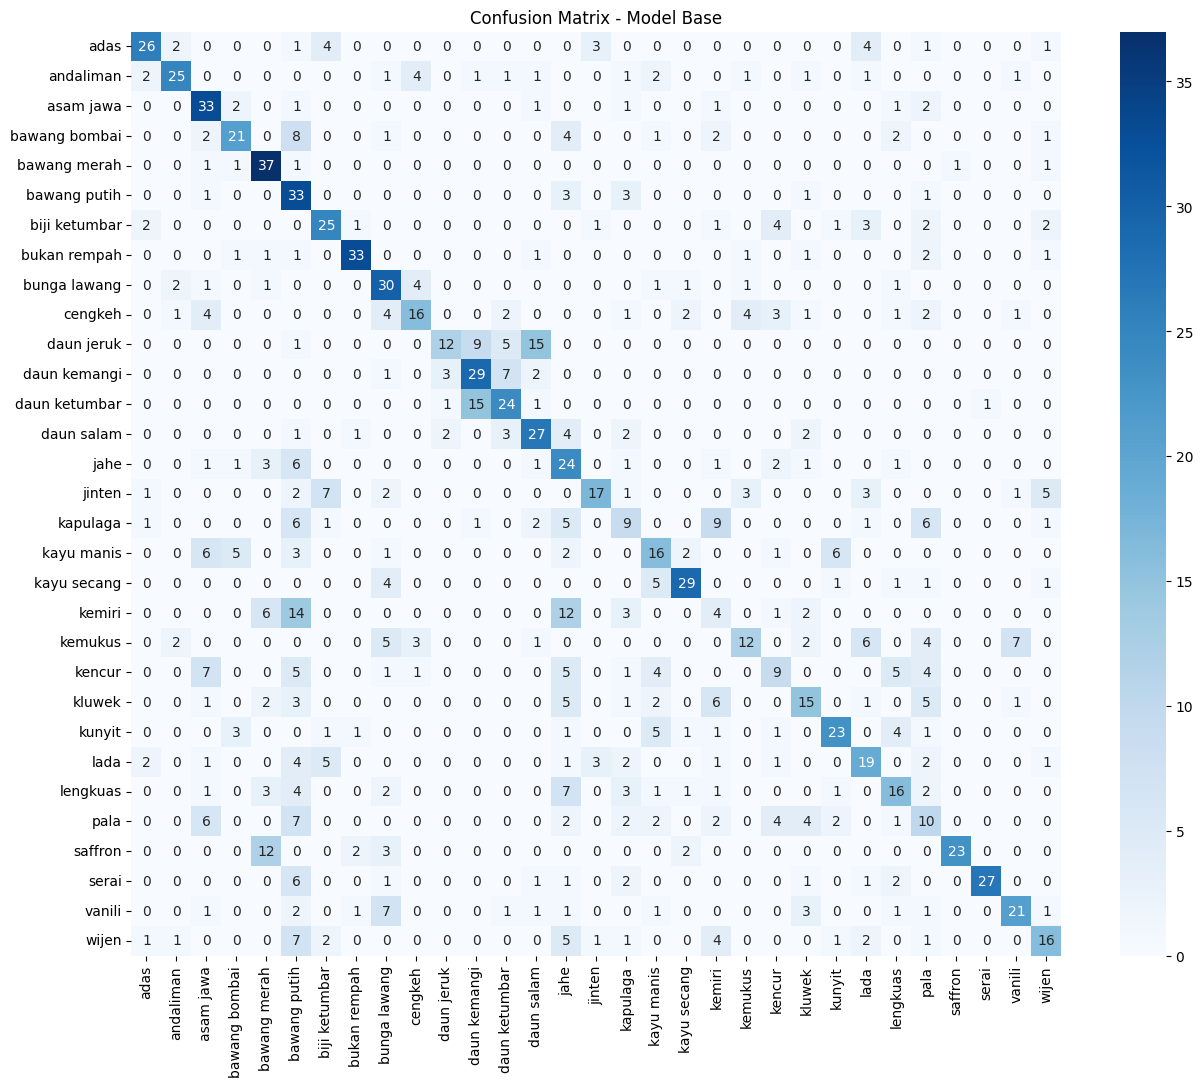

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Reset generator agar urutan data konsisten
val_generator.reset()
Y_pred_base = model_base.predict(val_generator)
y_pred_base = np.argmax(Y_pred_base, axis=1)
y_true = val_generator.classes
target_names = list(train_generator.class_indices.keys())

print("EVALUASI MODEL BASE")
print(classification_report(y_true, y_pred_base, target_names=target_names))

plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(y_true, y_pred_base), annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Model Base')
plt.show()

2. Evaluasi Model Pre-trained 1 (MobileNetV2)

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step
EVALUASI MOBILENETV2
               precision    recall  f1-score   support

         adas       0.79      0.90      0.84        42
    andaliman       0.92      0.86      0.89        42
    asam jawa       0.95      0.88      0.91        42
bawang bombai       0.95      0.98      0.96        42
 bawang merah       0.84      0.90      0.87        42
 bawang putih       0.90      0.86      0.88        42
biji ketumbar       0.74      0.76      0.75        42
 bukan rempah       1.00      0.98      0.99        42
 bunga lawang       0.84      0.86      0.85        42
      cengkeh       0.71      0.98      0.82        42
   daun jeruk       0.92      0.81      0.86        42
 daun kemangi       0.84      0.62      0.71        42
daun ketumbar       0.81      0.90      0.85        42
   daun salam       0.78      0.93      0.85        42
         jahe       0.76      0.67      0.71        42
       jinten       0.83      0.81      0.82        42
 

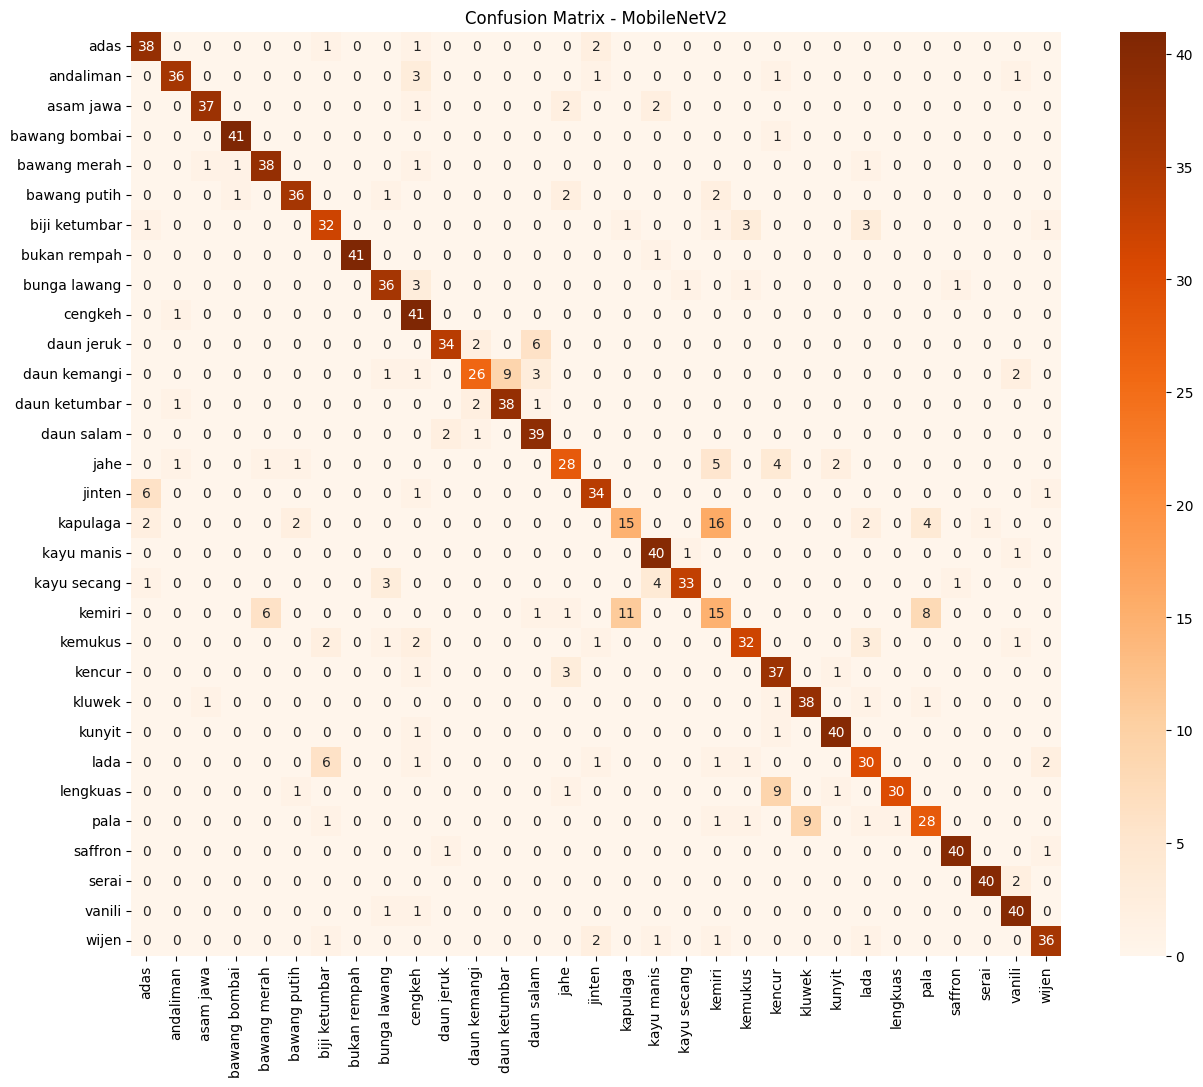

In [ ]:
val_generator.reset()
Y_pred_mnet = model_pretrained_1.predict(val_generator)
y_pred_mnet = np.argmax(Y_pred_mnet, axis=1)

print("EVALUASI MOBILENETV2")
print(classification_report(y_true, y_pred_mnet, target_names=target_names))

plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(y_true, y_pred_mnet), annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

3. Evaluasi Model Pre-trained 2 (VGG16)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step
EVALUASI VGG16
               precision    recall  f1-score   support

         adas       0.73      0.71      0.72        42
    andaliman       0.70      0.74      0.72        42
    asam jawa       0.86      0.74      0.79        42
bawang bombai       0.86      0.86      0.86        42
 bawang merah       0.58      0.74      0.65        42
 bawang putih       0.71      0.52      0.60        42
biji ketumbar       0.58      0.71      0.64        42
 bukan rempah       0.74      0.83      0.79        42
 bunga lawang       0.89      0.76      0.82        42
      cengkeh       0.57      0.83      0.68        42
   daun jeruk       0.77      0.81      0.79        42
 daun kemangi       0.74      0.62      0.68        42
daun ketumbar       0.58      0.90      0.70        42
   daun salam       0.77      0.79      0.78        42
         jahe       0.62      0.74      0.67        42
       jinten       0.90      0.64      0.75        42
     kap

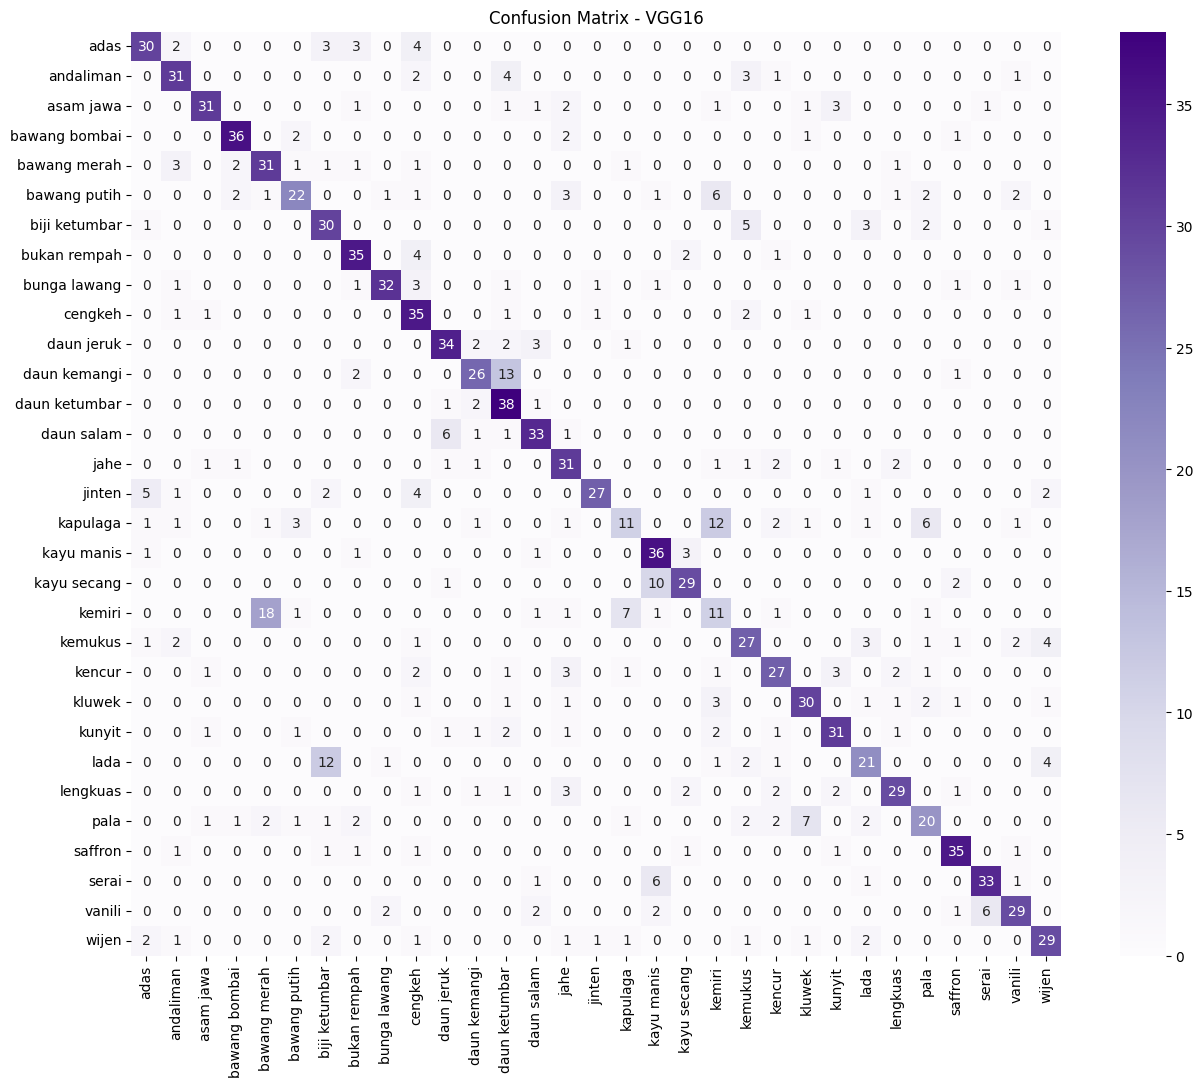

In [ ]:
val_generator.reset()
Y_pred_vgg = model_pretrained_2.predict(val_generator)
y_pred_vgg = np.argmax(Y_pred_vgg, axis=1)

print("EVALUASI VGG16")
print(classification_report(y_true, y_pred_vgg, target_names=target_names))

plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(y_true, y_pred_vgg), annot=True, fmt='d', cmap='Purples',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - VGG16')
plt.show()

# Save Model

In [ ]:
# Tentukan folder penyimpanan di Drive Anda
save_path = '/content/drive/MyDrive/UAP Machine Learning/Models/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Menyimpan ketiga model
model_base.save(save_path + 'model_base_rempah.h5')
model_pretrained_1.save(save_path + 'model_mobilenet_rempah.h5')
model_pretrained_2.save(save_path + 'model_vgg16_rempah.h5')

print(f"Sukses! Ketiga model telah disimpan di: {save_path}")

Sukses! Ketiga model telah disimpan di: /content/drive/MyDrive/UAP Machine Learning/Models/


# Streamlit

In [10]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np
import os

# 1. Konfigurasi Halaman
st.set_page_config(page_title="Klasifikasi Rempah Indonesia", layout="centered")

st.title("🌿 Sistem Klasifikasi Rempah Indonesia")
st.write("Unggah gambar rempah untuk mengetahui jenisnya menggunakan Model AI.")

# 2. Fungsi Load Model (Agar lebih ringan)
@st.cache_resource
def load_all_models():
    # Pastikan path ini sesuai dengan tempat Anda menyimpan model di Sel 16
    base = tf.keras.models.load_model('/content/drive/MyDrive/UAP Machine Learning/Models/model_base_rempah.h5')
    mnet = tf.keras.models.load_model('/content/drive/MyDrive/UAP Machine Learning/Models/model_mobilenet_rempah.h5')
    vgg = tf.keras.models.load_model('/content/drive/MyDrive/UAP Machine Learning/Models/model_vgg16_rempah.h5')
    return base, mnet, vgg

# 3. Daftar Kelas (Sesuaikan dengan urutan folder Anda)
class_names = ['adas', 'andaliman', 'asam jawa', 'bawang bombai', 'bawang merah', 'bawang putih',
               'biji ketumbar', 'bukan rempah', 'bunga lawang', 'cengkeh', 'daun jeruk',
               'daun kemangi', 'daun ketumbar', 'daun salam', 'jahe', 'jinten', 'kapulaga',
               'kayu manis', 'kayu secang', 'kemiri', 'kemukus', 'kencur', 'kluwek', 'kunyit',
               'lada', 'lengkuas', 'pala', 'saffron', 'serai', 'vanili', 'wijen']

# Load model
try:
    model_base, model_mnet, model_vgg = load_all_models()
    st.sidebar.success("Semua Model Berhasil Dimuat!")
except:
    st.sidebar.error("Model tidak ditemukan. Pastikan sudah menjalankan Sel 16.")

# 4. Sidebar untuk Pemilihan Model
st.sidebar.title("Pengaturan Model")
selected_model_name = st.sidebar.selectbox(
    "Pilih Model untuk Prediksi:",
    ("Neural Network Base", "MobileNetV2 (Terbaik)", "VGG16")
)

# 5. Input Data (Upload Gambar)
uploaded_file = st.file_uploader("Pilih Gambar...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Tampilkan Gambar
    image = Image.open(uploaded_file)
    st.image(image, caption='Gambar yang diunggah', use_container_width=True)

    # Preprocessing
    img = image.resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Pilih model yang digunakan
    if selected_model_name == "Neural Network Base":
        model = model_base
    elif selected_model_name == "MobileNetV2 (Terbaik)":
        model = model_mnet
    else:
        model = model_vgg

    # Prediksi
    if st.button("Klasifikasikan Sekarang"):
        with st.spinner('Sedang menganalisis...'):
            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            result = class_names[np.argmax(predictions)]
            conf = np.max(predictions) * 100

            st.success(f"### Hasil Prediksi: **{result}**")
            st.info(f"Tingkat Keyakinan: {conf:.2f}%")
            st.write(f"Menggunakan Model: {selected_model_name}")

Writing app.py


In [12]:
# 1. Install Library yang Dibutuhkan
!pip install -q streamlit pyngrok

# 2. Masukkan Authtoken Anda di sini
NGROK_AUTH_TOKEN = "37AZRJ4zMdcWJpJaZtAsx2XYF5q_JJwUHp1pAJGHBayApXLH"

from pyngrok import ngrok
import subprocess

# 3. Autentikasi Ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# 4. Jalankan Streamlit di Background
# Pastikan app.py sudah dibuat di sel sebelumnya
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])

# 5. Buka Tunnel Ngrok
# Ini akan memberikan link publik yang stabil
public_url = ngrok.connect(8501)
print("Link Demo Anda (Klik untuk membuka):", public_url)

Link Demo Anda (Klik untuk membuka): NgrokTunnel: "https://nonregimented-abe-chignoned.ngrok-free.dev" -> "http://localhost:8501"
